# PAE second stage

PAE consists of 2 stages: 

1) an Auto-Encoder (AE) that was trained to reach optimal reconstructions     

2) a normalizing flow trained to Gaussianize the latent space of the AE    

Both need to be trained *separately* otherwise the model will not be optimal. 
The PAE outperforms VAEs because of that split. The AE should not be replaced by an VAE, otherwise you will pay penalty in model performance.


This notebook contains code to train the second stage (the normalizing flow).

*Nomenclature*: I will refer to the latent space variable of the AE as *z* or embedded space. And I will refer to the latent space of the normalizing flow as *u* or latent space.

The bijector of the normalizing flow in this notebook is made out of  transformation layers and permutation layers. The tranformations can either be a shift and rescale transformation (RealNVP) or a spline transformation (Neural Spline Flow). Every second permutation layer is trainable (GLOW).

The user can set the number of layers of each transformation.

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

print(tf.__version__)

2.3.0


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

tfp.__version__

'0.11.0'

In [ ]:
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

Mounted at /content/drive


### Step 1: Load the AE embedded data. This will be the input data for training the normalizing flow.

In [ ]:
# loading embedding extracted from jupyter notebook
DATA_PATH = './drive/My Drive/Colab Notebooks'
emb = np.load(os.path.join(DATA_PATH,'beta=0.199.npy'))

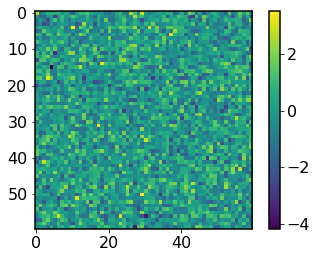

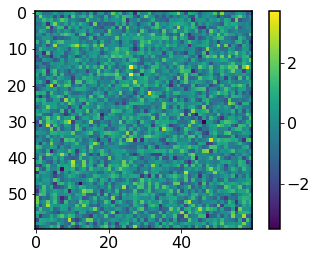

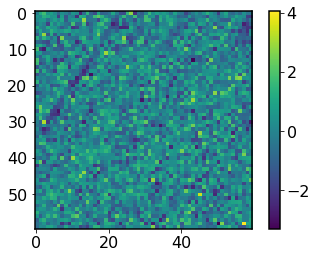

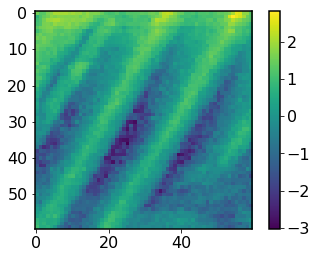

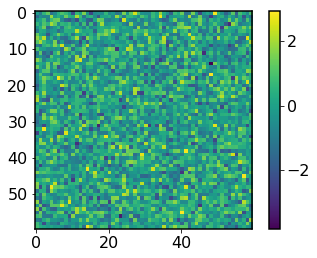

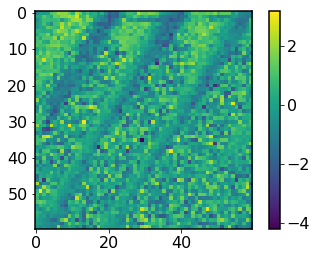

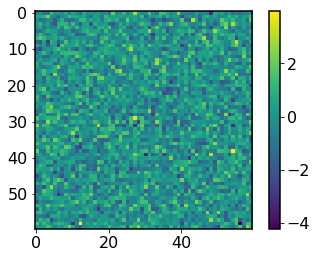

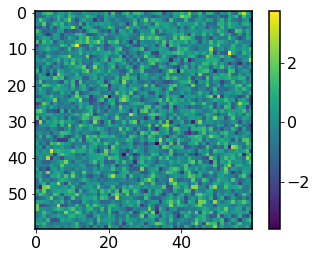

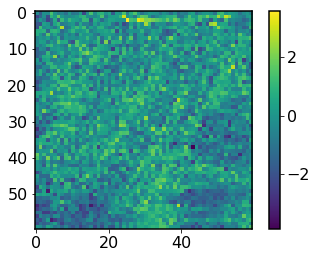

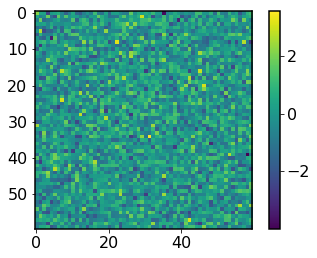

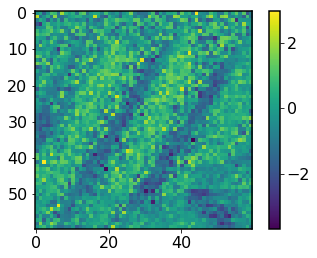

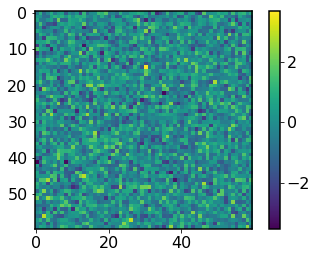

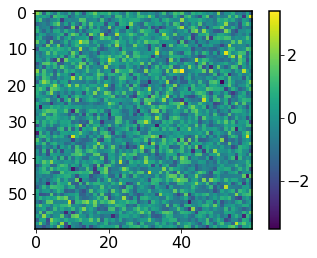

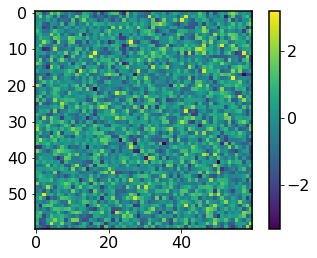

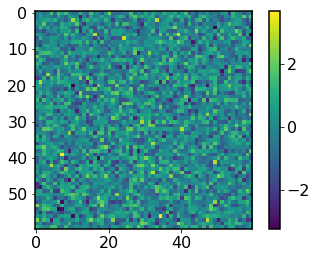

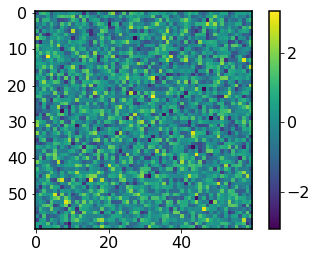

In [ ]:
for i in range(16):
    plt.figure()
    plt.imshow(emb[:,i].reshape(60,60))
    plt.colorbar()

Step 2: find or set dimensions that the model should use

In [ ]:
non_zero_dims = [3,5,8,10]

In [ ]:
# # finding non-zero embeddings
# non_zero_dims = []
# for ii in range(16):
#     if len(np.where(emb[:,ii]!=0.)[0])>0:
#         print(len(np.where(emb[:,ii]!=0.)[0]))
#         non_zero_dims.append(ii)
        
# print(non_zero_dims)

In [ ]:
# latent size is smaller than embedding size due to sparsity
params={}
params['latent_size']    = len(non_zero_dims)
params['embedding_size'] = emb.shape[-1]


where you want the model to be saved:

In [ ]:
# path for saving the model
params['module_dir'] = 'vae_simple_model/'

Step 3: design the normalizing flow. Set the number of layers that you want for each type of transformation.

In [ ]:
# number of transformations in the bijection
N_spline_layers = 2
N_rescale_shift_layers = 2
N_shift_layers = 2

In [ ]:
nvp_depth = N_spline_layers+N_rescale_shift_layers+N_shift_layers

Dont worry about the next cells, where I'm building the normalizing flow.

In [ ]:
dims         = np.asarray([len(non_zero_dims) for ii in range(nvp_depth)]) 
nvp_size     = np.arange(nvp_depth) 
indices      = np.arange(len(non_zero_dims))
nvp_depth    = N_spline_layers+N_rescale_shift_layers+N_shift_layers

In [ ]:
# target distribution
def get_prior(latent_size):
    return tfd.MultivariateNormalDiag(tf.zeros(latent_size), scale_identity_multiplier=1.0)

In [ ]:
# bijector for permutations (GLOW)

def trainable_lu_factorization(
    event_size, batch_shape=(), seed=None, dtype=tf.float32, name=None):
    with tf.name_scope(name or 'trainable_lu_factorization'):
        event_size = tf.convert_to_tensor(
            event_size, dtype_hint=tf.int32, name='event_size')
        batch_shape = tf.convert_to_tensor(
            batch_shape, dtype_hint=event_size.dtype, name='batch_shape')
        random_matrix = tf.random.uniform(
            shape=tf.concat([batch_shape, [event_size, event_size]], axis=0),
            dtype=dtype,
            seed=seed)
        random_orthonormal = tf.linalg.qr(random_matrix)[0]
        lower_upper, permutation = tf.linalg.lu(random_orthonormal)
        lower_upper = tf.Variable(
            initial_value=lower_upper,
            trainable=True,
            name='lower_upper')
        # Initialize a non-trainable variable for the permutation indices so
        # that its value isn't re-sampled from run-to-run.
        permutation = tf.Variable(
            initial_value=permutation,
            trainable=False,
            name='permutation')
        return lower_upper, permutation


In [ ]:
# splines for Neural Spline Flow

class SplineParams(tf.Module):

    def __init__(self, nunits, nbins=32):
        self._nbins = nbins
        self._nunits= nunits
        self._built = False
        self._bin_widths = None
        self._bin_heights = None
        self._knot_slopes = None

    def _bin_positions(self, x):
        x = tf.reshape(x, [-1,self._nunits,self._nbins])
        # you can try to take out layers here
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        net = tf.layers.Dense(self._nunits)(net)
        # net = tf.nn.leaky_relu(net)
        # net = tf.layers.Dense(self._nbins)(net)
        net = tf.reshape(net, [-1,self._nunits, self._nbins])
        return tf.math.softmax(net, axis=-1) * (2 - self._nbins * 1e-2) + 1e-2

    def _slopes(self, x):
        x = tf.reshape(x, [-1,  self._nunits, ( self._nbins - 1)])
        net = tf.layers.Dense(self._nunits)(x)
        net = tf.nn.leaky_relu(net)
        # net = tf.layers.Dense(self._nbins-1)(net)
        net = tf.reshape(net, [-1,  self._nunits, ( self._nbins - 1)])
        return tf.math.softplus(x) + 1e-2

    def __call__(self, x, nunits):

        bin_positions = self._bin_positions
        if not self._built:
            self._bin_widths  = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='w')
            self._bin_heights = tf.layers.Dense(self._nunits * self._nbins, activation=bin_positions, name='h')
            self._knot_slopes = tf.layers.Dense(self._nunits * (self._nbins - 1), activation=self._slopes, name='s')
        self._built = True
        result = tfb.RationalQuadraticSpline(bin_widths=self._bin_widths(x),bin_heights=self._bin_heights(x),knot_slopes=self._knot_slopes(x))
        
        return result

In [ ]:
def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)

def get_nvp():
    chain             = []
    reduction         = (params['latent_size']-dims)/params['latent_size']
    current_size      = []
    perms_swap        = []
    perms_rand        = []
    perms_train       = []
    splines           = []
    size              = []
    #current_size      = params['latent_size']
    for i,s in enumerate(nvp_size):
        current_size  = np.int(params['latent_size']*(1-reduction[i]))
        swapping      = np.concatenate((np.arange(current_size//2,current_size),np.arange(0, current_size//2)))
        perms_swap.append(tfb.Permute(permutation=init_once(swapping,name="perm_swap%d"%i)))
        perms_train.append(tfb.MatvecLU(*trainable_lu_factorization(current_size),validate_args=True, name="perms_train%d"%i))
        splines.append(SplineParams(current_size//2))
        size.append(current_size)
        print(current_size, size)


# model can be composed of different element of GLOW, NSF, Real NVP, use the if statements for modifications
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(tfb.Blockwise(bijectors=[perms_train[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        else:
            chain.append(tfb.Blockwise(bijectors=[perms_swap[i],tfb.Identity()],block_sizes=[size[i],params['latent_size']-size[i]]))
        if i<N_spline_layers: 
            # spline bijector
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,bijector_fn=splines[i])
        if i<N_spline_layers and i>N_shift_layers+N_spline_layers:
            # shift and scale 
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']]))                 
        else:
            bijector1 = tfb.RealNVP(num_masked=size[i]-size[i]//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=[params['latent_size'],params['latent_size']],shift_only=True))  
        bijector2 = tfb.Identity()
        chain.append(tfb.Blockwise(bijectors=[bijector1, bijector2], block_sizes=[size[i],params['latent_size']-size[i]]))
    # Neural spline flow needs to act on interval [-1,1], hence the scaling
    chain.append(tfb.Scale(5))
    
    # p(x) is Gaussian, chain: y=g(x)
    # bwd goes from last to first in the chain (inverse)
    nvp=tfd.TransformedDistribution(distribution=tfd.Normal(0,1),bijector=tfb.Chain(chain),name='mynvp', event_shape=(params['latent_size'],))
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

This is the graph of our model. It is just the model. Think of is as a class. It has not been filled with numbers yet. I will explain below how to use it.

In [ ]:
# model in good old tf1 style

tf.reset_default_graph()

# learning rate
lr            = tf.placeholder_with_default(0.001,shape=[])
# input data
data          = tf.placeholder(shape=[None,params['embedding_size']],dtype=tf.float32)
# input data
latent_sample = tf.placeholder(shape=[None,len(non_zero_dims)],dtype=tf.float32)
# ba
bs            = tf.placeholder_with_default(16,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
prior         = get_prior(params['latent_size'])

# ----------------------------------module to save the model----------------------------------------------------------#
nvp_spec  = hub.create_module_spec(nvp_module_spec)
# this is how you would load the module instead of creating a new one 
## nvp_funcs = hub.Module(params['module_dir'], trainable=True)
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
#---------------------------------------------------------------------------------------------------------------------#
# select non-zero dimensions of the data
comp_data      = tf.gather(data,non_zero_dims,axis=1)
#-------------------------------------------------training------------------------------------------------------------#
log_prob       = nvp_funcs({'z_sample':comp_data,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob']
# the training loss is transformed distribution
loss           = -tf.reduce_mean(log_prob)
# evaluates one training step
opt_op_nvp     = optimizer.minimize(loss)
#---------------------------------------------------------------------------------------------------------------------#


#project into Gaussian space
bwd            = nvp_funcs({'z_sample':comp_data,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass']
#draw from the Gaussian 
prior_sample   = prior.sample(bs)
# fwd model these draws back into the embedding space
fwd            = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':latent_sample},as_dict=True)['fwd_pass']

4 [4]
4 [4, 4]
4 [4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4, 4]
4 [4, 4, 4, 4, 4, 4]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# initialize the session to evaluate your graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Examples for how to use the model we have built.

Ex1 : evaluate the log probability of data under the model

In [ ]:
# the feed dict is the disctioanry of values that you feed into the graph. here it is the embedded data.
log_prob_of_emb = sess.run(log_prob, feed_dict={data:emb})

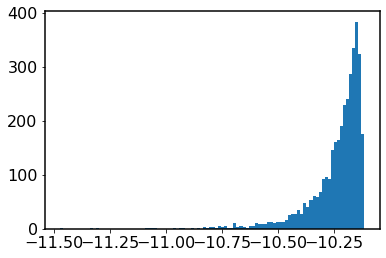

In [ ]:
# note that this is before we have trained the model
_  = plt.hist(log_prob_of_emb, bins=100)

### Ex 2.: Transforming data from z-sapce to u-space (embedded data to Gaussianized data)

In [ ]:
u_data = sess.run(bwd, feed_dict={data:emb})

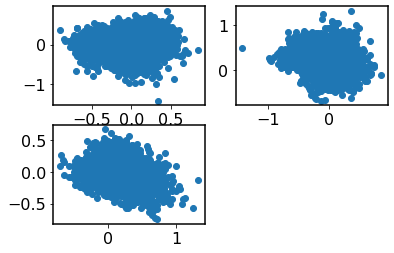

In [ ]:
# input data in 'Gaussian' space
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(u_data[:,ii],u_data[:,ii+1])

### Ex 3.:  Draw a random sample in the Gaussian space (u-space) and bring it into the embedded space (z_space)

In [ ]:
# draw random sample from normal of size 1024
u_sample = sess.run(prior_sample, feed_dict={bs:1024})

In [ ]:
# bring this sanmple into the embedded space of the auto-enocder
z_sample = sess.run(fwd,  feed_dict={latent_sample: u_sample})

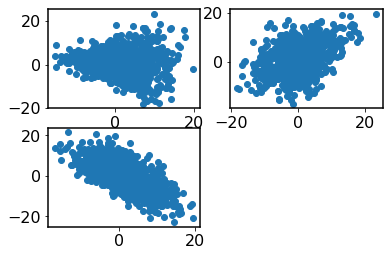

In [ ]:
# random samples in z_space (note again, we havent trained the model yet, so the output will not match the embedded data)
for ii in range(params['latent_size']-1):
    plt.subplot(2,2, ii+1)
    plt.scatter(z_sample[:,ii],z_sample[:,ii+1])

For your purpose, if after training you wanted to interpolate between two embedded points and look at the result in the data space, you would:

1) encode the data points with the AE

2) encode the embedded data points with the NF by running code like in example 2

3) interpolate/ move the points in this space

4) forward model the new points with code like in example 3 (not the random sampling just the fwd step) 

5) forward model with the decoder of the autoencoder



### Ex 4: Evaluate the loss (negative log probability) and perform one training step

In [ ]:
# loss for batch of 16 data points
loss_batch = sess.run(loss,  feed_dict={data: emb[0:16]})

In [ ]:
loss_batch

10.244189

In [ ]:
# one optimization step (need to pass training data and learning rate)
_  = sess.run(opt_op_nvp,  feed_dict={data: emb[0:16], lr:1e-3})

In [ ]:
# loss after optimziation step
sess.run(loss,  feed_dict={data: emb[0:16]})

10.229944

## Training

In [ ]:
nvp_tloss = []
nvp_vloss = []
ii     = 0

In [ ]:
# splitting into training and validation data
train_size = int(len(emb)/6*5)
print('sample size of training sample', train_size)
z_sample   = emb[:train_size]
z_sample_valid = emb[train_size:,] 
valid_size = len(z_sample_valid)
print('sample size of validation sample', valid_size)
z_sample_train = z_sample[:]

sample size of training sample 3000
sample size of validation sample 600


In [ ]:
# set initial learning rate, batchsize and number of epochs
learning_rate = 1e-3
batchsize     = 16
n_epochs      = 20


break_count =0
while ii<n_epochs:
    print('epoch ', ii)
    # number of iterations for one epoch given current batchsize
    epoch = train_size//batchsize
    jj    = 0 
    while jj<epoch:
        # take one optimization step and evaluate current loss
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate, data:z_sample_train[jj*batchsize:(jj+1)*batchsize]})
        jj+=1

    ll = sess.run(loss,  feed_dict={lr: learning_rate, data:z_sample_train[:len(z_sample_valid)]})
    nvp_tloss.append(ll)
    lv = sess.run(loss,  feed_dict={lr: learning_rate, data:z_sample_valid})
    print('train loss: ', ll, 'val loss: ', lv)
    nvp_vloss.append(lv)
    # reshuffle data before next training epoch
    np.random.shuffle(z_sample) 
    if ii%20==0 and ii>0:
      # saves the model at regular intervals
        nvp_path = os.path.join(params['module_dir'],'run1_nepoch%d'%ii)
        try:
            nvp_funcs.export(nvp_path,sess)
        except:
            pass
    ii+=1

epoch  0
train loss:  7.7538023 val loss:  7.7452464
epoch  1
train loss:  5.7583 val loss:  5.681747
epoch  2
train loss:  5.580893 val loss:  5.545562
epoch  3
train loss:  5.5814304 val loss:  5.592574
epoch  4
train loss:  5.475369 val loss:  5.6054006
epoch  5
train loss:  5.5619683 val loss:  5.607848
epoch  6
train loss:  5.6147614 val loss:  5.530721
epoch  7
train loss:  5.5764866 val loss:  5.555357
epoch  8
train loss:  5.584961 val loss:  5.5963764
epoch  9
train loss:  5.521397 val loss:  5.5998583
epoch  10
train loss:  5.4919014 val loss:  5.582798
epoch  11
train loss:  5.422786 val loss:  5.521004
epoch  12
train loss:  5.5011587 val loss:  5.545541
epoch  13
train loss:  5.543681 val loss:  5.6353836
epoch  14
train loss:  5.624341 val loss:  5.6171203
epoch  15
train loss:  5.476167 val loss:  5.603779
epoch  16
train loss:  5.494628 val loss:  5.611159
epoch  17
train loss:  5.3915963 val loss:  5.5772934
epoch  18
train loss:  5.5249662 val loss:  5.5692053
epoch  

you will probably need to implement a learning schedule (decrease learning rate and increase batchsize with increasing number of epochs, and then possibly 'restart', where you go up again in learning rate or down in batchsize and then let it settle again)

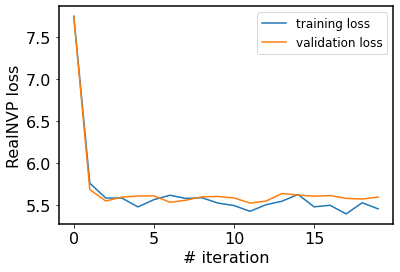

In [ ]:
plt.figure()
plt.plot(np.asarray(nvp_tloss),label='training loss')
plt.plot(np.asarray(nvp_vloss),label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.legend()

### Save the trained model:

In [ ]:
nvp_path = os.path.join(params['module_dir'],'run2_nepoch%d'%ii)
nvp_funcs.export(nvp_path,sess)

## Plots to test how well the model has performed

### 1) compare distributions in u-space. Data in u_space should match Gaussian prior

In [ ]:
bwd_train = sess.run(bwd,  feed_dict={data:z_sample})
bwd_valid = sess.run(bwd,  feed_dict={data:z_sample_valid})
Gaussian_sample = sess.run(prior_sample,  feed_dict={bs:len(z_sample)})

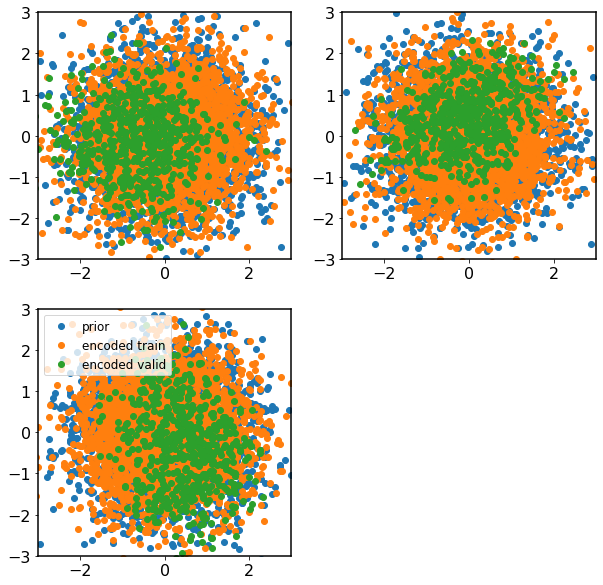

In [ ]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(2,2, nn+1)
    plt.scatter(Gaussian_sample[:,nn],Gaussian_sample[:,nn+1], label='prior')
    plt.scatter(bwd_train[:,nn],bwd_train[:,nn+1],label='encoded train')
    plt.scatter(bwd_valid[:,nn],bwd_valid[:,nn+1], label='encoded valid')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
plt.legend()
plt.show()

### 1) compare distributions in z-space. Data in z_space should match Gaussian prior samples forward modeled to z-space

In [ ]:
fwd_sample = sess.run(fwd, feed_dict={latent_sample:Gaussian_sample})
input_data = sess.run(comp_data,  feed_dict={data:emb})

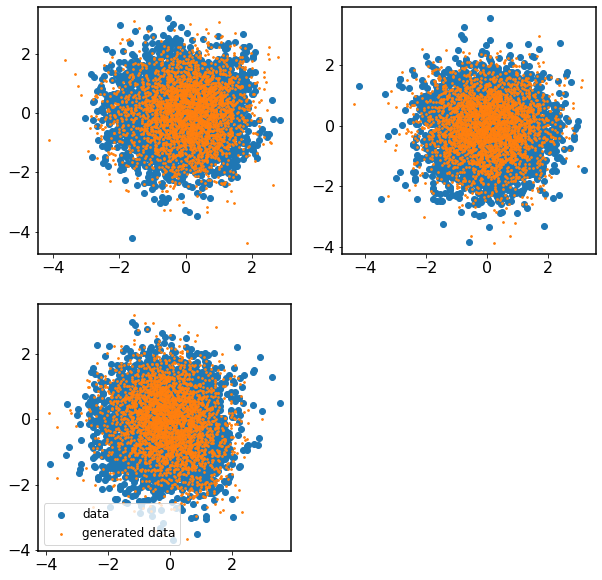

In [ ]:
plt.figure(figsize=(10,10))
for nn in range(params['latent_size']-1):
    plt.subplot(2,2, nn+1)
    plt.scatter(input_data[:,nn],input_data[:,nn+1], label='data')
    plt.scatter(fwd_sample[:,nn],fwd_sample[:,nn+1],s=3, label='generated data')
plt.legend()